In [1]:
%load_ext nb_black


def warn(*args, **kwargs):  # to remove convergence warning
    pass


import warnings

warnings.warn = warn
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoLarsCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from math import sqrt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import statsmodels.api as sm

<IPython.core.display.Javascript object>

# Introduction

In this notebook, we will try to predict the price of houses using several machine learning technics. You can find the data in the following link:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Let's first import and check our datasets.

In [2]:
train = pd.read_csv("D:/data/house/train.csv")
test = pd.read_csv("D:/data/house/test.csv")
print("the length of the training set is: {}.".format(len(train)))
print("the length of the test set is: {}.".format(len(test)))

the length of the training set is: 1460.
the length of the test set is: 1459.


<IPython.core.display.Javascript object>

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<IPython.core.display.Javascript object>

We won't use the test dataset because we don't have the target variable. However, we can predict on this dataset and look for the performance on Kaggle if needed.

# Data preprocessing

## Missing values

As we can see above, there is some missing values in the dataset. We will check which columns contain them and how we can deal with them.

In [5]:
percent_missing = train.isnull().sum() * 100 / len(train)
percent_missing = percent_missing.sort_values(ascending=False).to_frame()
percent_missing = percent_missing.loc[percent_missing.iloc[:, 0] > 0]
print("There are {} features with nan values.".format(len(percent_missing)))
percent_missing

There are 19 features with nan values.


,0
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageCond,5.547945
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945


<IPython.core.display.Javascript object>

After checking the data description, we can see that most of the missing values are just here to indicate that the feature is not in the house. For exemple, if PoolQC has a missing value, it means that there is no pool in the house. So we can create a new category for those missing values which is 0, indicating the absence of this feature in the house.

The only feature where we cannot apply this logic is the variable 'electrical' so let's study this feature a bit further.

In [6]:
print(
    "Total missing values for Electrical: {}.".format(
        train["Electrical"].isnull().sum()
    )
)
print(train["Electrical"].value_counts())
train["Electrical"] = train["Electrical"].fillna("SBrkr")
print(
    "Total missing values for Electrical: {}.".format(
        train["Electrical"].isnull().sum()
    )
)

Total missing values for Electrical: 1.
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
Total missing values for Electrical: 0.


<IPython.core.display.Javascript object>

As we can see, there is only one row with a missing value so I choose to replace it with the most common value.

We can now replace the missing values with 0 for the other features.

In [7]:
train = train.fillna(0)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

## Distribution

As we know we don't have any missing values, we can check our feature distribution.

In the data description, it is explicit that most of the numerical features are skew, which means that there is more weight on the right tail of the distribution. In other word, most of our data have a unbalanced distribution which can affect our performance when using linear models.

To make it more explicit, we will plot two of those variables.

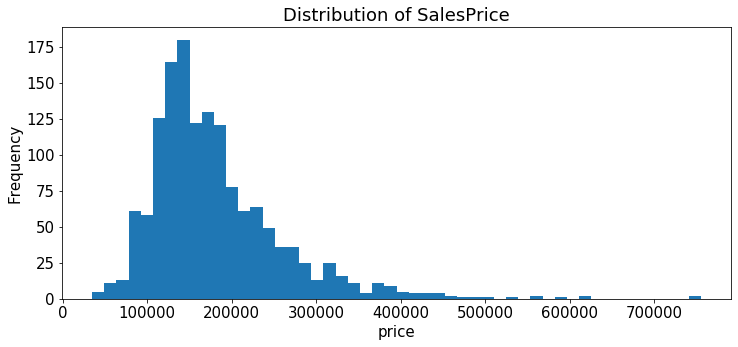

<IPython.core.display.Javascript object>

In [8]:
plt.rcParams.update({"font.size": 15})
plt.figure(figsize=(12, 5))
plt.hist(
    train["SalePrice"], bins=50
)  # , weights=np.ones(len(train['SalePrice'])) / len(train['SalePrice']), bins=15)
plt.xlabel("price")
plt.ylabel("Frequency")
plt.title("Distribution of SalesPrice")
plt.show()

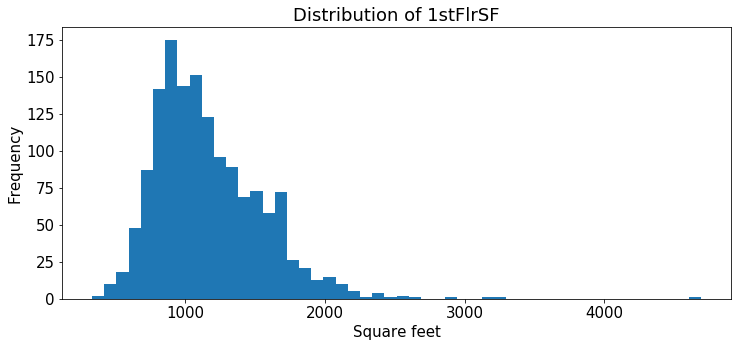

<IPython.core.display.Javascript object>

In [9]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(12,5))
plt.hist(train['1stFlrSF'], bins = 50)#, weights=np.ones(len(train['SalePrice'])) / len(train['SalePrice']), bins=15)
plt.xlabel('Square feet')
plt.ylabel('Frequency')
plt.title('Distribution of 1stFlrSF')
plt.show()


Instead of removing the extreme values, we will take the log(1+x) of the most skew features including the target variable. We will be able to put back the values in the normal scale after the predictions.

We will also keep a copy of the original data (without the log scale) to check if changing the scale increase the performance.

In [10]:
# keep a copy of the data
train2 = train.copy()

# log transform the target:
y = train["SalePrice"]

from scipy.stats import skew

# log transform skewed numeric features:
numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(
    lambda x: skew(x.dropna())
)  # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train[skewed_feats] = np.log1p(train[skewed_feats])

<IPython.core.display.Javascript object>

Let's now have a look at the distribution of the previous variable.

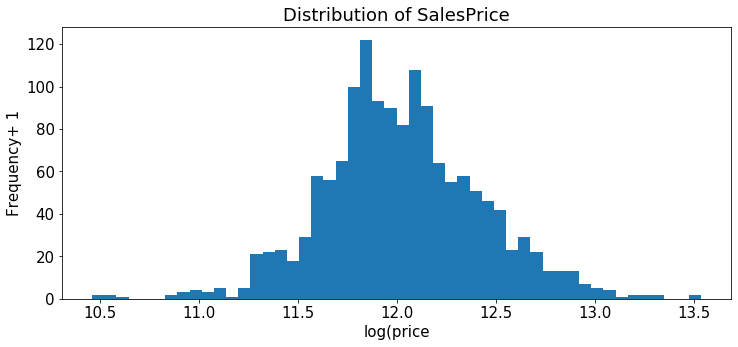

<IPython.core.display.Javascript object>

In [11]:
plt.rcParams.update({"font.size": 15})
plt.figure(figsize=(12, 5))
plt.hist(
    train["SalePrice"], bins=50
)  # , weights=np.ones(len(train['SalePrice'])) / len(train['SalePrice']), bins=15)
plt.xlabel("log(price")
plt.ylabel("Frequency+ 1")
plt.title("Distribution of SalesPrice")
plt.show()

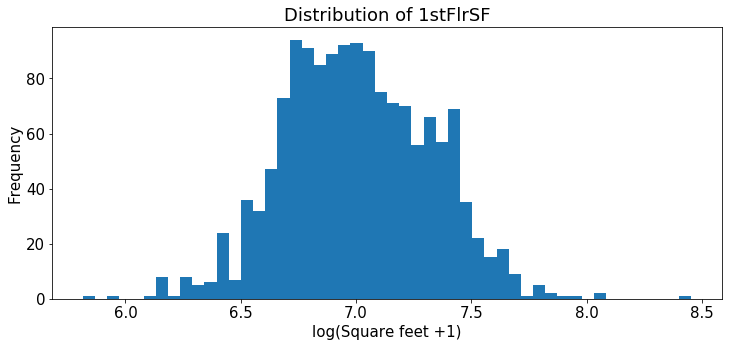

<IPython.core.display.Javascript object>

In [12]:
plt.rcParams.update({"font.size": 15})
plt.figure(figsize=(12, 5))
plt.hist(
    train["1stFlrSF"], bins=50
)  # , weights=np.ones(len(train['SalePrice'])) / len(train['SalePrice']), bins=15)
plt.xlabel("log(Square feet +1)")
plt.ylabel("Frequency")
plt.title("Distribution of 1stFlrSF")
plt.show()

As we can see, the distribution are way less unbalanced than before, so our linear models should perform better.

## Categorical features

Now let's check how many categorical features do we have.

In [13]:
print(
    "There are:{} categorical features.".format(
        len(train.select_dtypes(include="object").columns)
    )
)
train.select_dtypes(include="object")

There are:43 categorical features.


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,0,0,0,WD,Normal
1,RL,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,0,0,0,WD,Normal
2,RL,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,0,0,0,WD,Normal
3,RL,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,0,0,0,WD,Abnorml
4,RL,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,0,0,0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,0,0,0,WD,Normal
1456,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,0,MnPrv,0,WD,Normal
1457,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,0,GdPrv,Shed,WD,Normal
1458,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,0,0,0,WD,Normal


<IPython.core.display.Javascript object>

We will replace them with dummies (one binary column for each categorical of a feature).

In [14]:
train = pd.get_dummies(train)
train2 = pd.get_dummies(train2)
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.110874,65.0,9.042040,7,5,2003,2003,5.283204,6.561031,...,0,0,0,1,0,0,0,0,1,0
1,2,3.044522,80.0,9.169623,6,8,1976,1976,0.000000,6.886532,...,0,0,0,1,0,0,0,0,1,0
2,3,4.110874,68.0,9.328212,7,5,2001,2002,5.093750,6.188264,...,0,0,0,1,0,0,0,0,1,0
3,4,4.262680,60.0,9.164401,7,5,1915,1970,0.000000,5.379897,...,0,0,0,1,1,0,0,0,0,0
4,5,4.110874,84.0,9.565284,8,5,2000,2000,5.860786,6.486161,...,0,0,0,1,0,0,0,0,1,0


<IPython.core.display.Javascript object>

## Adding features

To have more information, it's a common practice to add the squared value of the numerical features.

In [15]:
#Get the numerical columns
num_features = train.drop(['Id','SalePrice'],axis =1).select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

#Add squared
for i in num_features:
    train['{}_square'.format(i)] = train['{}'.format(i)] * train['{}'.format(i)]


<IPython.core.display.Javascript object>

In [16]:
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea_square,WoodDeckSF_square,OpenPorchSF_square,EnclosedPorch_square,3SsnPorch_square,ScreenPorch_square,PoolArea_square,MiscVal_square,MoSold_square,YrSold_square
0,1,4.110874,65.0,9.042040,7,5,2003,2003,5.283204,6.561031,...,300304,0.000000,17.033238,0.000000,0.0,0.0,0.0,0.0,4,4032064
1,2,3.044522,80.0,9.169623,6,8,1976,1976,0.000000,6.886532,...,211600,32.495057,0.000000,0.000000,0.0,0.0,0.0,0.0,25,4028049
2,3,4.110874,68.0,9.328212,7,5,2001,2002,5.093750,6.188264,...,369664,0.000000,14.146626,0.000000,0.0,0.0,0.0,0.0,81,4032064
3,4,4.262680,60.0,9.164401,7,5,1915,1970,0.000000,5.379897,...,412164,0.000000,12.841608,31.466174,0.0,0.0,0.0,0.0,4,4024036
4,5,4.110874,84.0,9.565284,8,5,2000,2000,5.860786,6.486161,...,698896,27.695908,19.737150,0.000000,0.0,0.0,0.0,0.0,144,4032064


<IPython.core.display.Javascript object>

# Most important features

Before lauching our predictions, let's have a look at the most important features and the linear relation between our target variable and the covariables.

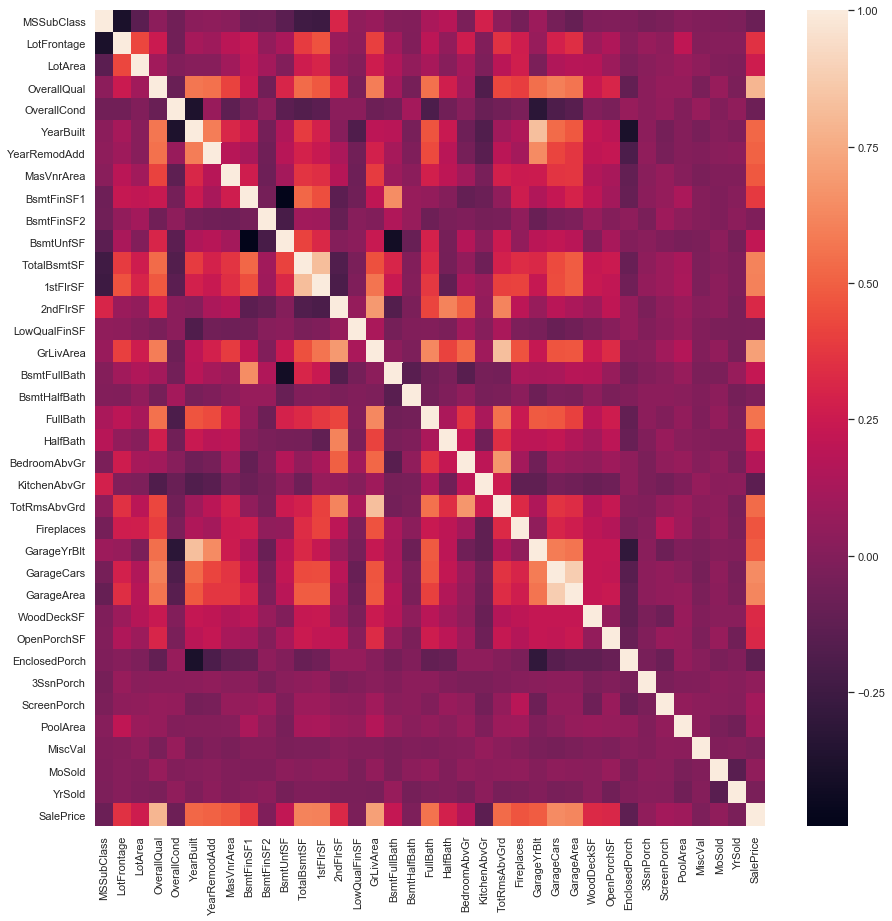

<IPython.core.display.Javascript object>

In [17]:
##correlation
for_cor = pd.read_csv('D:/data/house/train.csv')
corr_var = for_cor.drop('Id',axis =1).corr()
del for_cor
sns.set(rc={'figure.figsize':(15,15)}) 
sns.heatmap(corr_var, 
        xticklabels=corr_var.columns,
        yticklabels=corr_var.columns)


We can see that there is a lot of correlation between our data.

In [18]:
X = train.drop(columns=["SalePrice"], axis=1).copy()
y = train["SalePrice"].copy()
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     77.24
Date:                Tue, 27 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:41:31   Log-Likelihood:                 1464.4
No. Observations:                1460   AIC:                            -2345.
Df Residuals:                    1168   BIC:                            -801.2
Df Model:                         291                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   318.80

<IPython.core.display.Javascript object>

We see that we have a high R-squared (0.951) which means there is a strong linear relation between our dependent variable and the covariables. 

Regarding the p-values, as we have a probably a lot of collinearity, it is possible that their values are imprecises so we cannot affirm which features are more important based on those values.

# Prediction

In this section, we will create models to predict the SalePrice variable.

First, we need to create our training and test set.

In [19]:
# Create the training and test set with the log scale
X = train.drop(columns=["SalePrice"], axis=1).copy()
y = train["SalePrice"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=69
)

# Create the training and test set without the log scale

X2 = train2.drop(columns=["SalePrice"], axis=1).copy()
y2 = train2["SalePrice"].copy()

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.1, random_state=69
)

# Create a list to save the best models and their performances.
mylist = []

<IPython.core.display.Javascript object>

Let's define our training functions. We will use cross-validation on the training set and report the performance on the test set. 

Our metric will be the RMSE because we want to give more weight to the large errors.

In [20]:
def training(model, X_train, X_test, y_train, y_test, params):
    """Take the data with log scale, perform a gridsearchcv, transform the data back to the normal scale
    and return the best model, the performance(RMSE) and the scale"""

    cv = GridSearchCV(model, params).fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    # rmse_log = (sqrt(mean_squared_error(y_test,y_pred)))
    rmse = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    return [cv.best_estimator_, rmse, "log scale"]


def training2(model, X_train, X_test, y_train, y_test, params):
    """Take the data with normal scale, perform a gridsearchcv and return the best model, the performance(RMSE)
    and the scale."""

    cv = GridSearchCV(model, params).fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return [cv.best_estimator_, rmse, "normal scale"]

<IPython.core.display.Javascript object>

As a first model, we will use a simple method: use the mean on the training set to predict the test set. We are doing this to have a very simple (and bad) model to compare our models with.

In [21]:
# log scale
mean_y = y_train.mean()
# X_test = X_test.reset_index()
y_pred = pd.DataFrame({"y_pred": np.tile(mean_y, X_test.reset_index().index.max() + 1)})
rmse = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
mylist.append(["Mean", rmse, "log scale"])

# normal scale
mean_y = y_train2.mean()
# X_test2 = X_test2.reset_index()
y_pred = pd.DataFrame(
    {"y_pred": np.tile(mean_y, X_test2.reset_index().index.max() + 1)}
)
rmse = sqrt(mean_squared_error(y_test2, y_pred))
mylist.append(["Mean", rmse, "normal scale"])

<IPython.core.display.Javascript object>

We can now start with linear models.

In [22]:
params = {}
perf1 = training(LinearRegression(), X_train, X_test, y_train, y_test, params)
perf2 = training2(LinearRegression(), X_train2, X_test2, y_train2, y_test2, params)
mylist.append(perf1)
mylist.append(perf2)
print(
    "RMSE with log_scale data: {}, RMSE with normal scale data: {}.".format(
        perf1[1], perf2[1]
    )
)

RMSE with log_scale data: 21247.77531672293, RMSE with normal scale data: 26243.031741417788.


<IPython.core.display.Javascript object>

In [23]:
params = {"alpha": [0.05, 0.1, 0.3, 1, 3, 5, 7, 10, 13, 15, 20]}
perf1 = training(Ridge(), X_train, X_test, y_train, y_test, params)
perf2 = training2(Ridge(), X_train2, X_test2, y_train2, y_test2, params)
mylist.append(perf1)
mylist.append(perf2)
print(
    "RMSE with log_scale data: {}, RMSE with normal scale data: {}.".format(
        perf1[1], perf2[1]
    )
)

RMSE with log_scale data: 19407.136619360484, RMSE with normal scale data: 21054.265627344666.


<IPython.core.display.Javascript object>

In [24]:
params = {"alpha": [0.0001, 0.001, 0.01]}
perf1 = training(Lasso(), X_train, X_test, y_train, y_test, params)
perf2 = training2(Lasso(), X_train2, X_test2, y_train2, y_test2, params)
mylist.append(perf1)
mylist.append(perf2)
print(
    "RMSE with log_scale data: {}, RMSE with normal scale data: {}.".format(
        perf1[1], perf2[1]
    )
)

RMSE with log_scale data: 19698.317546953487, RMSE with normal scale data: 23549.10020642245.


<IPython.core.display.Javascript object>

In [25]:
parameters = {"alpha": [0.0001, 0.001, 0.01], "l1_ratio": [0.8, 0.9, 0.5]}
perf1 = training(ElasticNet(max_iter=10000), X_train, X_test, y_train, y_test, params)
perf2 = training2(
    ElasticNet(max_iter=10000), X_train2, X_test2, y_train2, y_test2, params
)
mylist.append(perf1)
mylist.append(perf2)
print(
    "RMSE with log_scale data: {}, RMSE with normal scale data: {}.".format(
        perf1[1], perf2[1]
    )
)

RMSE with log_scale data: 19288.02107487269, RMSE with normal scale data: 21450.203430532303.


<IPython.core.display.Javascript object>

Let's try with the non-linear models:

In [26]:
params = {
    "n_estimators": [
        100,
        120,
    ],
    "max_depth": [None, 3, 5],
    "min_samples_split": [2, 3, 4],
}
perf1 = training(RandomForestRegressor(), X_train, X_test, y_train, y_test, params)
perf2 = training2(RandomForestRegressor(), X_train2, X_test2, y_train2, y_test2, params)
mylist.append(perf1)
mylist.append(perf2)
print(
    "RMSE with log_scale data: {}, RMSE with normal scale data: {}.".format(
        perf1[1], perf2[1]
    )
)

RMSE with log_scale data: 29184.435159078173, RMSE with normal scale data: 28133.566102261128.


<IPython.core.display.Javascript object>

In [27]:
params = {
    "learning_rate": [0.2, 0.3],
    "n_estimators": [150, 300, 400],
    "max_depth": [2, 3],
    "max_features": ["sqrt", 100, 200, None],
}
perf1 = training(GradientBoostingRegressor(), X_train, X_test, y_train, y_test, params)
perf2 = training2(
    GradientBoostingRegressor(), X_train2, X_test2, y_train2, y_test2, params
)
mylist.append(perf1)
mylist.append(perf2)
print(
    "RMSE with log_scale data: {}, RMSE with normal scale data: {}.".format(
        perf1[1], perf2[1]
    )
)

RMSE with log_scale data: 25553.41033076061, RMSE with normal scale data: 23230.78370266141.


<IPython.core.display.Javascript object>

# Results

We can now report the performance of our models.

In [28]:
results = pd.DataFrame(mylist, columns=["model", "rmse", "scale"])
results["model"] = results["model"].apply(lambda x: str(x))
results["model"] = [x.split("(")[0] for x in results["model"]]
results["model"] = results["model"].map(lambda x: x.lstrip("0"))
pd.pivot_table(
    results, values=["rmse"], index=["model"], columns=["scale"], aggfunc=np.mean
)

rmse              
scale                         log scale  normal scale
model                                                
ElasticNet                 19288.021075  21450.203431
GradientBoostingRegressor  25553.410331  23230.783703
Lasso                      19698.317547  23549.100206
LinearRegression           21247.775317  26243.031741
Mean                       78005.319079  76384.476075
RandomForestRegressor      29184.435159  28133.566102
Ridge                      19407.136619  21054.265627

<IPython.core.display.Javascript object>

Our models perform better than the basic model.So we see that our linear models are performing better than our non linear ones. Regarding the log(x+1) scale, we can see that  it improves globally our performances on linear models. However, the non linear models seems to perform less well. 

The Elastic Net, Lasso and Ridge are performing better than the normal Linear Regression. One of the reason is that we have multicollinearity in our data and those models performs better than a normal regression thanks to the regularization. 

So we have a best RMSE of 19288 with the ElasticNet Regression, which means that, in average, our models have a error of 19288 when prediction a sale price. 

To finish, we can stack the prediction of our best models to create a more robust model.


In [29]:
model1 = Ridge(
    alpha=20,
    copy_X=True,
    fit_intercept=True,
    max_iter=None,
    normalize=False,
    random_state=None,
    solver="auto",
    tol=0.001,
)
model2 = Lasso(
    alpha=0.001,
    copy_X=True,
    fit_intercept=True,
    max_iter=1000,
    normalize=False,
    positive=False,
    precompute=False,
    random_state=None,
    selection="cyclic",
    tol=0.0001,
    warm_start=False,
)
model3 = ElasticNet(
    alpha=0.001,
    copy_X=True,
    fit_intercept=True,
    l1_ratio=0.5,
    max_iter=10000,
    normalize=False,
    positive=False,
    precompute=False,
    random_state=None,
    selection="cyclic",
    tol=0.0001,
    warm_start=False,
)
models = [model1, model2, model3]

stack_perf = []

for model in models:
    model = model.fit(X_train, y_train)
    stack_perf.append(model.predict(X_test))

stack_perf = np.transpose(stack_perf)
y_pred = (stack_perf[:, 0] + stack_perf[:, 1] + stack_perf[:, 2]) / 3
y_pred
print("RMSE:", sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

RMSE: 19294.50476277846


<IPython.core.display.Javascript object>

In our case, the performance of the stacked regressions (19295) is less accurate than our previous best model with a RMSE of 19288.

This concludes our project. We predicted the sales price of house with a RMSE of 19288.

Here some area of improvement: 

- More feature engineering: there are a lot of features, one can analysis each of them and create new ones.
- Try more models
